## Timing Comparisons Between C++ and Ansys

In [ ]:
from simsopt.configs.zoo import get_hsx_data
import cadquery as cq
import numpy as np

The goal of this Notebook is to perform a timing comparison between ANSYS and our custom one-dimensional integral method in order to hopefully demonstrate our method's success. First, we load the coil that we wish to work with.  

In [23]:
a = 0.01 #minor radius
pts = get_hsx_data(Nt_coils=16, Nt_ma=10, ppp=200)[0][0].gamma()

We then convert the HSX coil into a `.step` file so that it can be loaded into the finite element analysis (FEA) software Ansys.

In [24]:
def CAD_coil(points, a):
    #convert from meters to mm for CAD
    points *= 1000
    a *= 1000
    
    # Scale system to order(1)
    scale = 1.0 / a
    len = points.shape[0]
    points = points * scale
    points = np.concatenate((points, points)) 
    points = [tuple(points[i]) for i in range(points.shape[0])]

    # Create two cleanly-cut solid halves of the coil
    path_1 = cq.Workplane().spline(points[0:len-1]).val() 
    path_2 = cq.Workplane().spline(points[int(0.5*len):int(1.5*len)-1]).val()
    tp_1 = cq.Plane(origin=path_1.positionAt(0), normal=path_1.tangentAt(0))
    tp_2 = cq.Plane(origin=path_2.positionAt(0), normal=path_2.tangentAt(0))
    sp = cq.Plane(origin=path_1.positionAt(0.25), normal=path_1.tangentAt(0.25))
    seg_1 = cq.Workplane(tp_1).circle(1).sweep(path_1)
    seg_1 = cq.Workplane(sp).add(seg_1).center(0,0).split(keepTop=True)
    seg_2 = cq.Workplane(tp_2).circle(1).sweep(path_2)
    seg_2 = cq.Workplane(sp).add(seg_2).center(0,0).split(keepBottom=True)
    
    # Fuse the coil together
    scaled_res = cq.Workplane().add(seg_1.union(seg_2))

    # Scale system back to original size
    result = cq.Workplane()
    for o in scaled_res.objects:
        result = result.add(o.scale(1.0/scale))
    
    #Generate a cross-section for visualization
    cross_section = cq.Workplane(tp_1).circle(a).extrude(0.001).faces(">Z")

    return result, cross_section

result, cross_section = CAD_coil(pts, a)
cq.exporters.export(result, "data/hsx.step")
cq.exporters.export(cross_section, "data/cross_section.step")
# display(result)

## Self-Force

The force data came from running `force_plots(Wire::hsx(0.326955182*0.01, 1e6, 1), 0, 200, "f_profiles", 0,1e-9, 1e-9);` in `runner.cpp`.

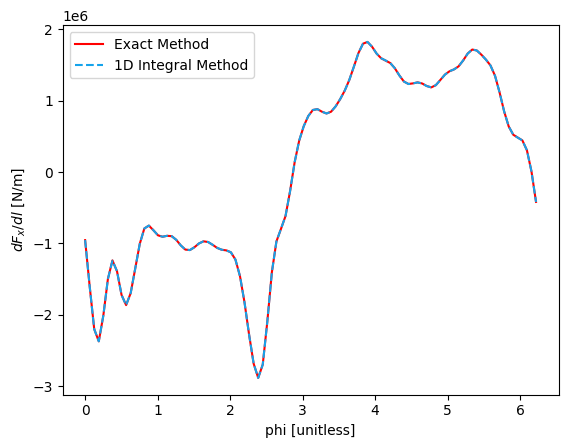

In [13]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

f = open("data/f_profiles.txt", "r")
matplotlib.rcParams.update({'font.size': 10})

ar = np.loadtxt(f)
phi = ar[:, 0]
fhi = ar[:, 1]
flo = ar[:, 2]

plt.plot(phi, fhi, label="Exact Method",color="red")
plt.plot(phi, flo, '--', label="1D Integral Method",color="#15A3EB")
plt.xlabel('phi [unitless]')
plt.ylabel(r'$dF_x/dl$ [N/m]')
plt.legend()
plt.show()

## Magnetic Field

Here, we generate contours of the magnetic field and compare between the 1D integral method "lofi" and the high-fidelity exact method "hifi". The data can be generated from the `runner.cpp` C++ file using the `contours_1D` and `contours` methods, respectively. To generate the data displayed below, the following code was executed:
```
contours_1D(Wire::hsx(0.326955182*0.1, 1e6, 1), 0, 70, "lofi"); //lofi |B| contour data
contours(Wire::hsx(0.326955182*0.1, 1e6, 1), 0, 70, "hifi"); //hifi |B| contour data
```



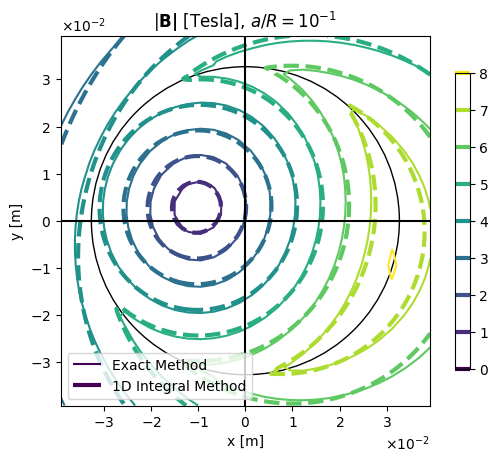

In [10]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def contour(exactname,lofiname, radius, phi):
    matplotlib.rcParams.update({'font.size': 10})
    k=0
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    f = open("data/"+ exactname + ".txt", "r")

    ar = np.loadtxt(f)
    x = ar[:, 0]
    y = ar[:, 1]
    b = ar[:, 2]

    # convert 1d array to meshgrid
    X, Y = np.meshgrid(np.unique(x), np.unique(y))
    B = np.empty(np.shape(X))
    for i in range(np.shape(B)[0]):
        for j in range(np.shape(B)[1]):
            wherex = np.where(x == X[i, j])
            wherey = np.where(y == Y[i, j])
            loc = np.intersect1d(wherex, wherey)[0]
            B[i, j] = b[loc]
            if (b[loc] == 0):
                B[i, j] = math.nan
                print(B[i, j])

    CS1 = ax.contour(X, Y, B, 8,levels=[0,1,2,3,4,5,6,7,8]) #,linestyles='dashed'

    f = open("data/"+ lofiname + ".txt", "r")

    ar = np.loadtxt(f)
    x = ar[:, 0]
    y = ar[:, 1]
    b = ar[:, 2]

    # convert 1d array to meshgrid
    X, Y = np.meshgrid(np.unique(x), np.unique(y))
    B = np.empty(np.shape(X))
    for i in range(np.shape(B)[0]):
        for j in range(np.shape(B)[1]):
            wherex = np.where(x == X[i, j])
            wherey = np.where(y == Y[i, j])
            loc = np.intersect1d(wherex, wherey)[0]
            B[i, j] = b[loc]
            if (b[loc] == 0):
                B[i, j] = math.nan
                print(B[i, j])

    CS2 = ax.contour(X, Y, B, 8, linestyles='dashed', linewidths=3, levels=[0,1,2,3,4,5,6,7,8]) #,linestyles='dashed'

    # plot axes and circle representing wire boundary
    circle1 = plt.Circle((0, 0), radius, color='black', fill=False)
    ax.add_patch(circle1)
    ax.axhline(y=0, color='black')
    ax.axvline(x=0, color='black')
    ax.set_title(r'$|\bf{B}|$ [Tesla], $a/R=10^{-1}$')
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')

    plt.ticklabel_format(axis='both', style='sci', scilimits=(0, 0), useMathText=True)
    h1, _ = CS1.legend_elements()
    h2, _ = CS2.legend_elements()
    ax.legend([h1[0], h2[0]], ['Exact Method', '1D Integral Method'],loc='lower left')
    CB = fig.colorbar(CS2, shrink=0.8)
    plt.show()

contour("hifi","lofi", 0.326955182*0.1,0)



## Self-Inductance

Here, we evaluate the accuracy of the self-inductance as calculated in the 2D integral model using data obtained by executing the following code in `runner.cpp`:
```
L_plots(100, "L_hifi", 1e-9,1e-9, 1e-4, Wire::hsx(0.00326955182, 1e6, 1).a_self_intersect()*0.99/0.326955182);
L_2D_plots(100,"L_lofi",1e-12,1e-12,1e-4, Wire::hsx(0.00326955182, 1e6, 1).a_self_intersect()*0.99/0.326955182);
```

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

f_hifi = open("data/L_hifi.txt", "r")
f_lofi = open("data/L_lofi.txt", "r")

ar_hi = np.loadtxt(f_hifi)
ar_lo = np.loadtxt(f_lofi)

asp_rat = ar_hi[:, 0]
l_hifi =ar_hi[:, 1]
l_lofi = ar_lo[:, 1]

matplotlib.rcParams.update({'font.size': 10})
plt.plot(asp_rat, l_hifi, color="red",label="Exact Method")
plt.plot(asp_rat, l_lofi, '--', color="#15A3EB",label="2D Integral Method")
plt.xlabel('Inverse aspect ratio (a/R) [unitless]')
plt.ylabel('Inductance [H]')
plt.xscale("log")
plt.legend()
plt.show()

We also evalaute the numerical convergence of the self-inductance solutions with respect to number of grid points. This data was obtained by running `L_2D_convergence_plots("L_conv",100,Wire::hsx(0.00326955182, 1e6, 1));` in `runner.cpp`.


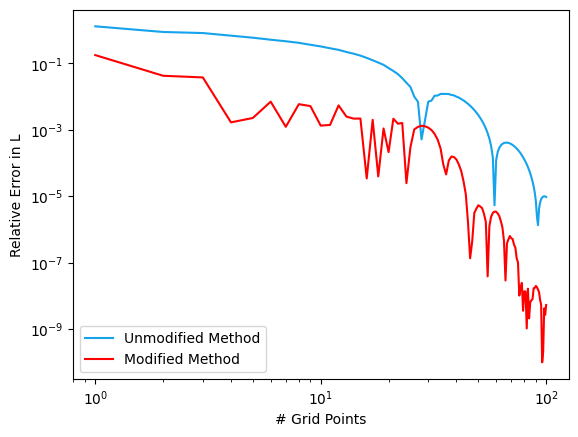

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

f = open("data/L_conv.txt", "r")
matplotlib.rcParams.update({'font.size': 10})

ar = np.loadtxt(f)
grid = ar[:, 0]
mod = ar[:, 1]
unmod = ar[:, 2]

plt.plot(grid, unmod, label="Unmodified Method",color="#15A3EB")
plt.plot(grid, mod, label="Modified Method",color="red")
plt.xlabel('# Grid Points')
plt.ylabel('Relative Error in L')
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

## Comparing Accuracy of the Modified and Unmodified Regularized Biot-Savart Laws

The following data was obtained by executing the following command in `runner.cpp`:
```
biot_conv(0.326955182/100,600,"modified",{5,12},{12,40})
```

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 10})

f = open("data/modified.txt", "r")
ar = np.loadtxt(f)
phi = ar[:, 0]

plt.plot(phi, ar[:,2]*10**6, label="Modified, 12 Grid Points")
plt.plot(phi, ar[:,3]*10**6, label="Unmodified, 12 Grid Points",color="g")
plt.plot(phi, ar[:,4]*10**6, '--',label="Unmodified, 40 Grid Points",color="r")

plt.xlabel('phi [unitless]')
plt.ylabel(r'$B_{reg}$ [T]')
plt.legend()
plt.show()

## Plots of $\max_{s,\theta}|\textbf{B}|$

This compares the maximum magnetic field along a coil between three methods: a full, high fidelity method; numerically maximizing an analytic expression; and a fully analytic approximation. The data was obtained from `maxB_plots(Wire::hsx(0.00326955182, 1e6, 1),200, "maxB", 1e-3);` from `runner.cpp`. 

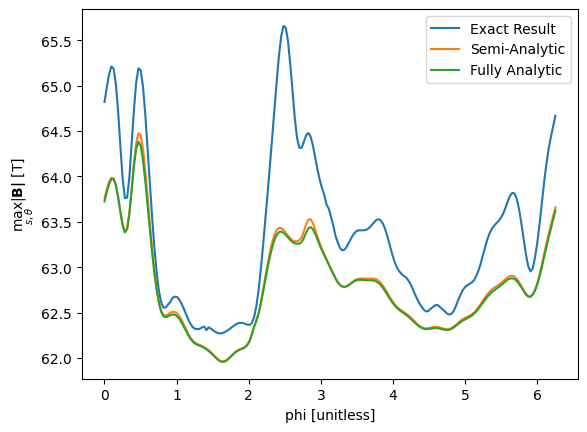

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'font.size': 10})

f = open("data/maxb.txt", "r")
ar = np.loadtxt(f)
phi = ar[:, 0]
hifi = ar[:, 1]
semi = ar[:, 2]
fully = ar[:,3]

plt.plot(phi, hifi, label="Exact Result")
plt.plot(phi, semi, label="Semi-Analytic")
plt.plot(phi, fully, label="Fully Analytic")

plt.xlabel('phi [unitless]')
plt.ylabel(r'$\max_{s,\theta}|\bf B |$ [T]')
plt.legend()
plt.show()